In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import researchpy as rp
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

from jupyterthemes import jtplot
jtplot.style(theme="grade3")

# Load Data

In [2]:
dataType = ["fastrtps_256", "fastrtps_128K", "opensplice_256", "opensplice_128K", "connext_256", "connext_128K"]

In [3]:
data = np.zeros([300, len(dataType)])
for i in range(len(dataType)):
    data[:, i] = np.loadtxt("./q4/"+str(dataType[i])+"byte.txt", dtype=np.float64) * 1000 # convert "s" to "ms"
    

# Make pd.Dataframe

In [4]:
fastrtps256 = pd.DataFrame(data[:, 0])
fastrtps128K = pd.DataFrame(data[:, 1])
opensplice256 = pd.DataFrame(data[:, 2])
opensplice128K = pd.DataFrame(data[:, 3])
connext256 = pd.DataFrame(data[:, 4])
connext128K = pd.DataFrame(data[:, 5])
df = [fastrtps256, fastrtps128K, opensplice256, opensplice128K, connext256, connext128K]

# Histogram Plot

In [5]:
def cap(x,quantile=[0.01,0.99]):
    """
    CAP Algorithm to delete the outliers
    
    Args：
        x：pd.Series
        quantile：upper/lower boundary in precentage
    """

    Q01,Q99=x.quantile(quantile).values.tolist()

    if Q01 > x.min():
        x = x.copy()
        x.loc[x<Q01] = Q01

    if Q99 < x.max():
        x = x.copy()
        x.loc[x>Q99] = Q99

    return(x)

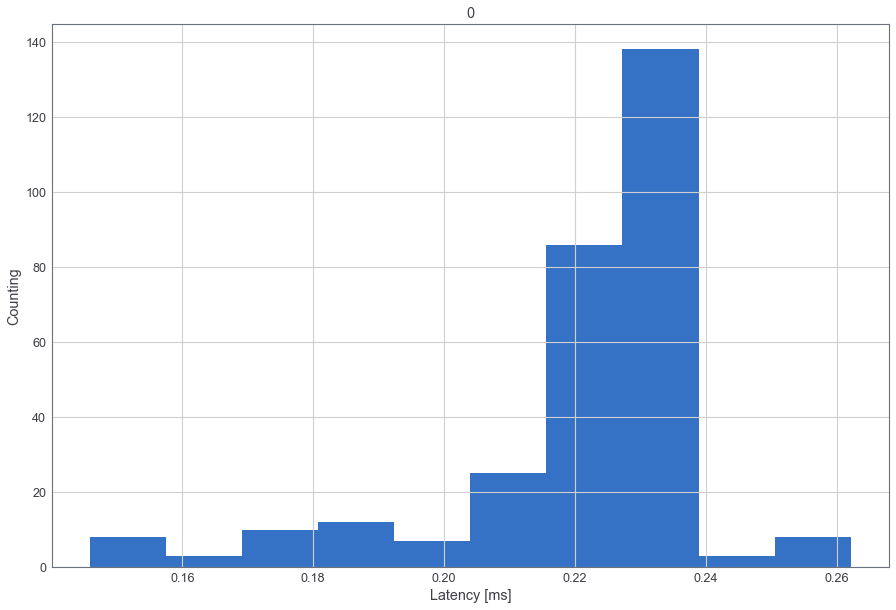

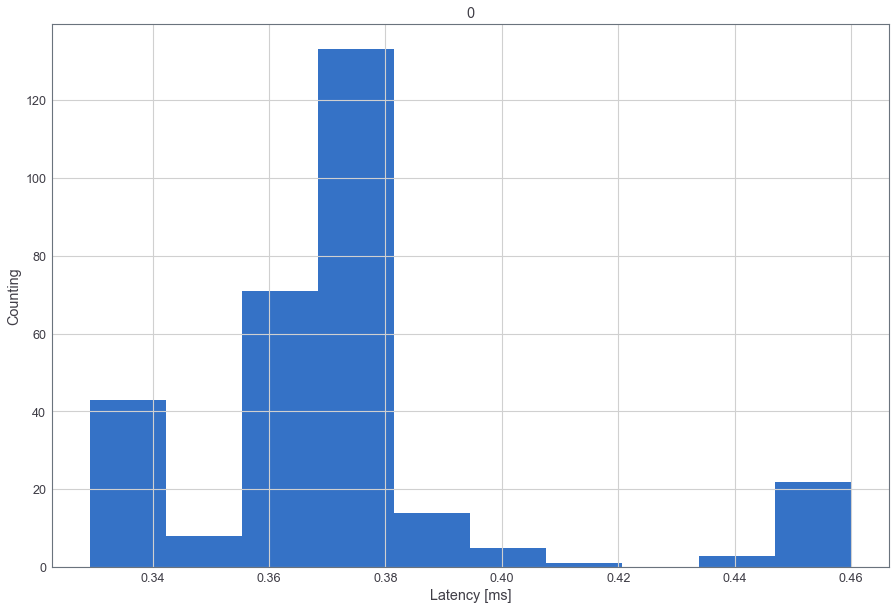

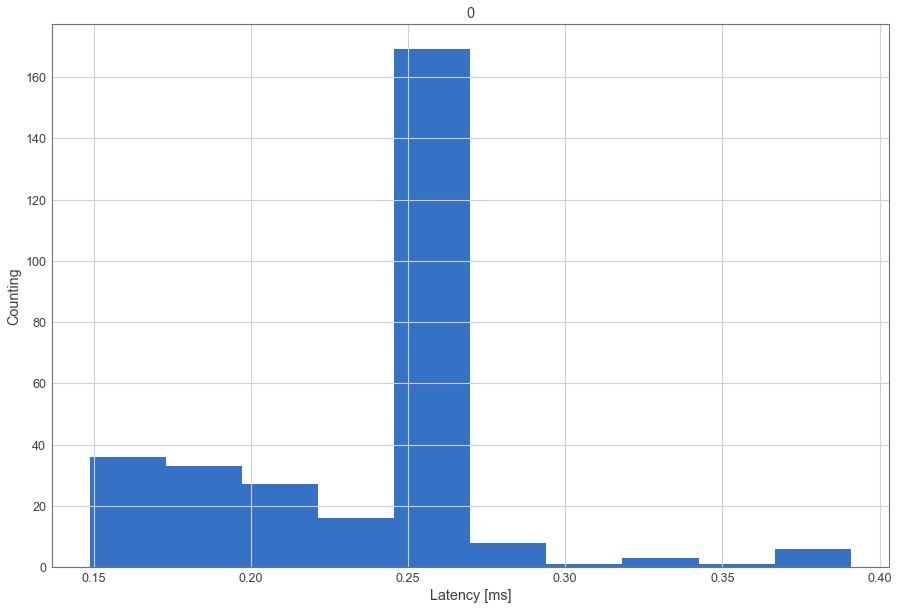

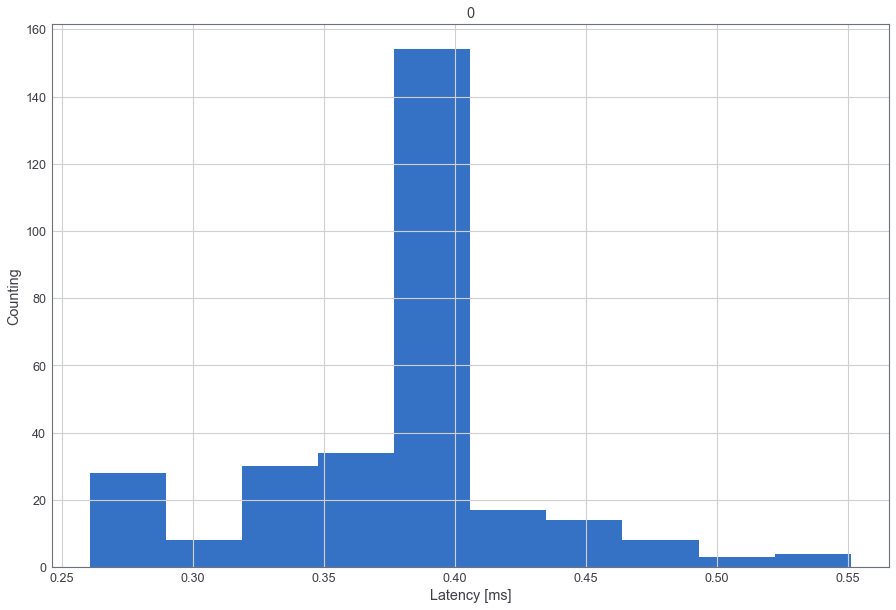

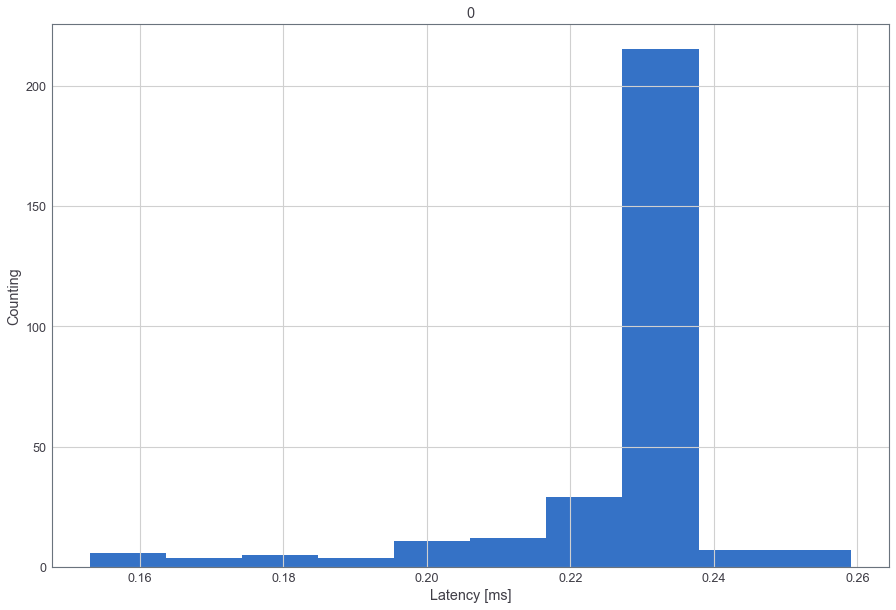

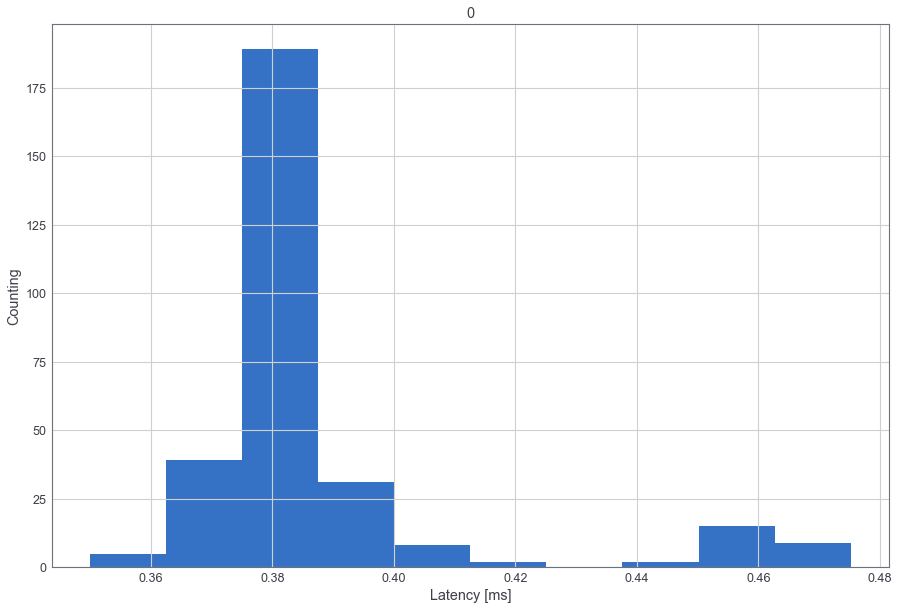

In [6]:
for i in range(6):
    temp = df[i].apply(cap, quantile=[0.01,0.99])
    boxfig = temp.hist(bins=10, figsize=(15,10))
    for axis in boxfig.flatten():
        axis.set_xlabel("Latency [ms]")
        axis.set_ylabel("Counting")
    plt.savefig("./q4/figure/"+dataType[i]+".png")

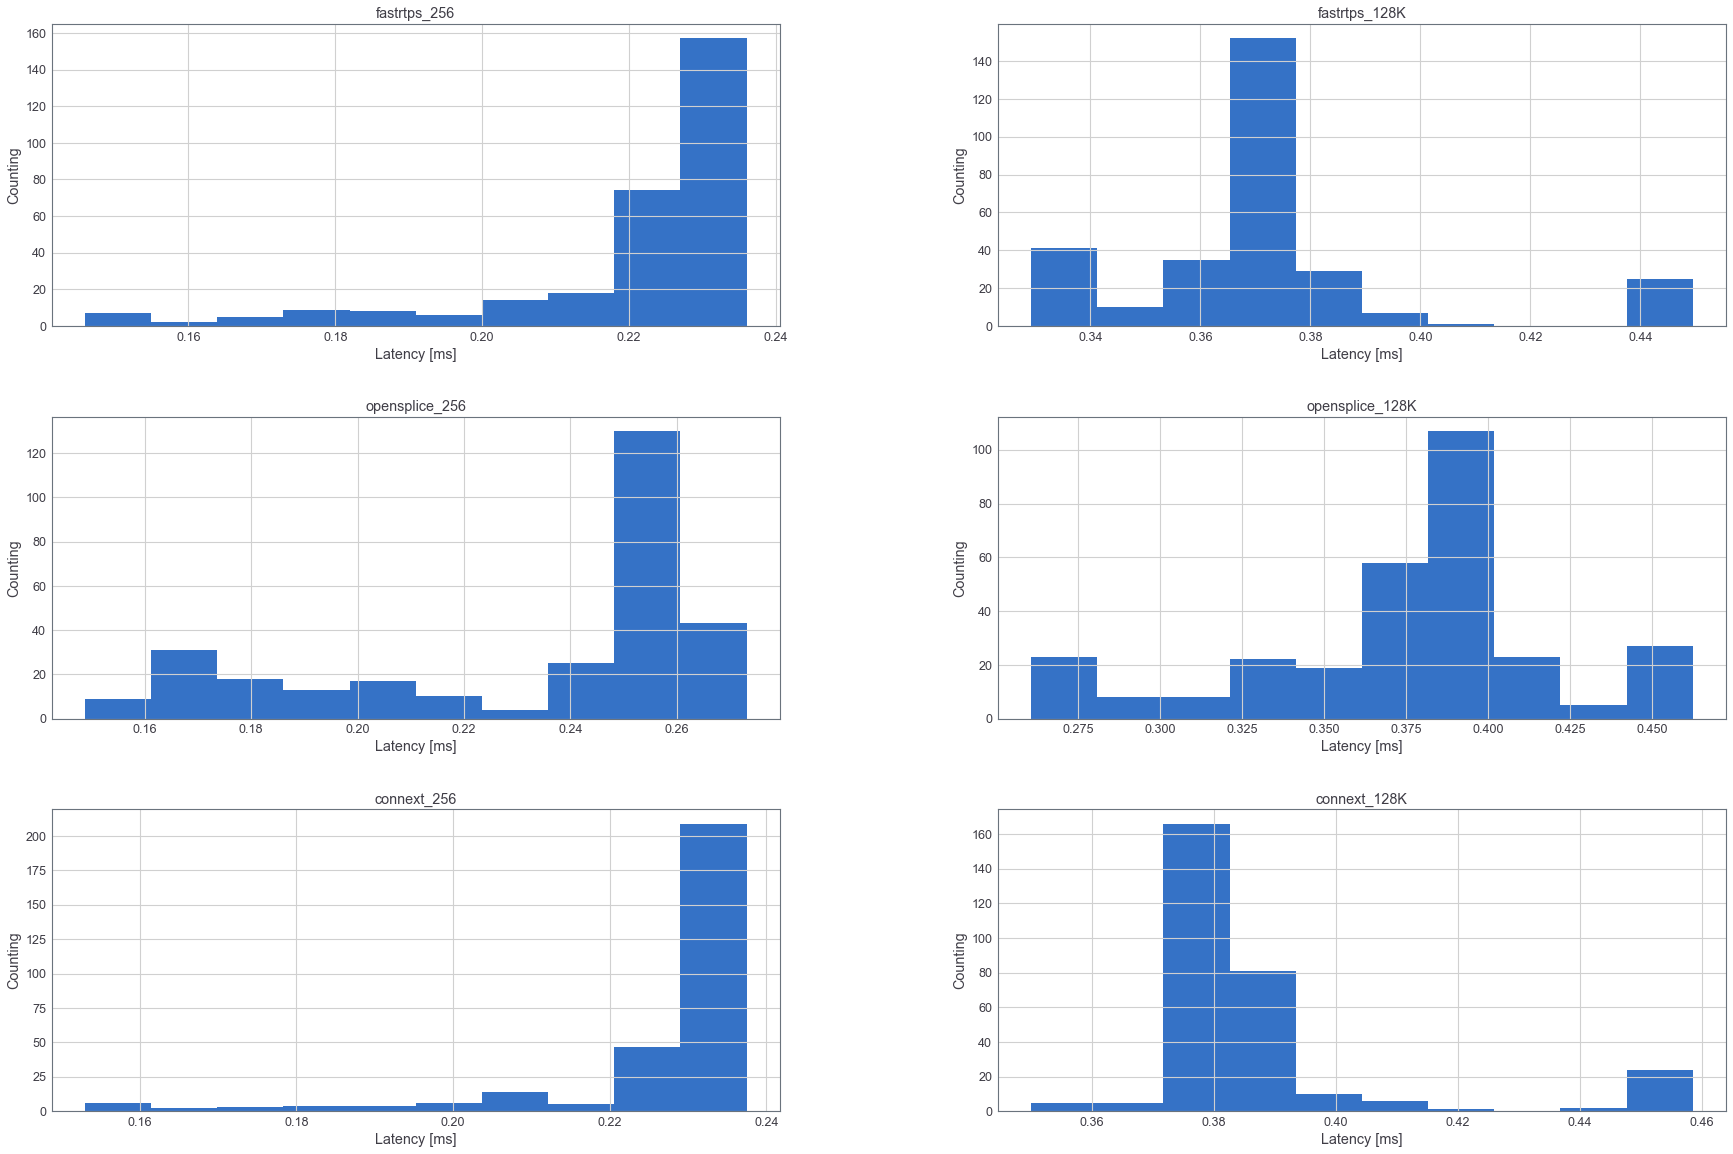

In [7]:
dfAll = pd.DataFrame(data, columns=dataType)
dfAll = dfAll.apply(cap, quantile=[0.01,0.95])
hisFigAll = dfAll.hist(bins=10, figsize=(30,20))
for axis in hisFigAll.flatten():
    axis.set_xlabel("Latency [ms]")
    axis.set_ylabel("Counting")
plt.savefig("./q4/figure/oneInAll.png", format="png", dpi=600)

# Anova - Test

In [8]:
anova = pd.DataFrame({
    "latency": data.flatten(),
    "DDS": np.repeat(["fastrtps", "opensplice", "connext"], 600),
    "size": np.r_[np.repeat(["256B", "128KB"], 300),
                  np.repeat(["256B", "128KB"], 300),
                  np.repeat(["256B", "128KB"], 300)
                 ]
})

In [9]:
rp.summary_cont(anova.groupby(['DDS', 'size']))['latency']

N    Mean      SD      SE  95% Conf.  Interval
DDS        size                                                   
connext    128KB  300  0.2945  0.0794  0.0046     0.2855    0.3035
           256B   300  0.2997  0.0792  0.0046     0.2907    0.3087
fastrtps   128KB  300  0.3109  0.0892  0.0052     0.3007    0.3210
           256B   300  0.6915  5.0738  0.2929     0.1150    1.2680
opensplice 128KB  300  0.2996  0.0802  0.0046     0.2905    0.3088
           256B   300  0.3026  0.0695  0.0040     0.2947    0.3105

In [10]:
model = ols('latency ~ C(DDS)*C(size)', anova).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 5, 1794) =  1.773, p =  0.1152


In [11]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                latency   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.773
Date:                Thu, 03 Dec 2020   Prob (F-statistic):              0.115
Time:                        01:44:52   Log-Likelihood:                -3863.0
No. Observations:                1800   AIC:                             7738.
Df Residuals:                    1794   BIC:                             7771.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.2945      0.120      2.461      0.014       0.060       0.529
C(DDS)[T.fastrtps]                       0.0164      0.169      0.097      0.923      -0.316       0.348
C(DDS)[T.opensplice]                     0.0052      0.169      0.030      0.976      -0.327       0.337
C(size)[T.256B]                          0.0052      0.169      0.031      0.976      -0.327       0.337
C(DDS)[T.fastrtps]:C(size)[T.256B]       0.3755      0.239      1.569      0.117      -0.094       0.845
C(DDS)[T.opensplice]:C(size)[T.256B]    -0.0022      0.239     -0.009      0.993      -0.472       0.467
==============================================================================
Omnibus:                     5277.367   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        194500029.484
Skew:                          39.328   Prob(JB):                         0.00
Kurtosis:                    1611.461   Cond. No.                         9.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(DDS),16.339216,2.0,1.901723,0.149612
C(size),7.560137,1.0,1.759850,0.184812
C(DDS):C(size),14.182515,2.0,1.650704,0.192206
Residual,7706.840925,1794.0,NaN,NaN
